<a href="https://colab.research.google.com/github/Yen-Yu-Chen/wk/blob/master/Copy_of_1_%E6%BA%96%E5%82%99%E8%A8%93%E7%B7%B4%E8%B3%87%E6%96%99_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# check google drive mounting
import os
if not os.path.isdir('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Google drive is mounted !")

Google drive is mounted !


## 匯入所有需要的套件模組

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  # 忽略所有 Warning
import datetime

# 資料下載

## 1-下載 CSSE COVID-19 Dataset
https://github.com/CSSEGISandData/COVID-19
(下載的位置為 /content/COVID-19)

In [ ]:
# 從 github 下載資料
!git clone 'https://github.com/CSSEGISandData/COVID-19'

fatal: destination path 'COVID-19' already exists and is not an empty directory.


### 讀取CSSE最新時間累積資料

In [ ]:
# Read global confirm data
CONFIRM_FILE = '/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirm_df = pd.read_csv(CONFIRM_FILE)
confirm_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,3,4,4,4,4,4,4,4,4,4,4,4
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


### 擷取台灣資料成為新的 DataFrame

In [ ]:
my_confirm_df = confirm_df.loc[confirm_df['Country/Region']=='Taiwan*']  # 選取台灣資料
my_confirm_df = my_confirm_df.iloc[:, 4:]  # 移除前4欄
my_confirm_df = my_confirm_df.transpose()  # 轉置, 日期成為index
# 重新命名欄位
column_name = my_confirm_df.columns
my_confirm_df = my_confirm_df.rename(columns={column_name[0]: "TW_confirm"})
my_confirm_df

,TW_confirm
1/22/20,1
1/23/20,1
1/24/20,3
1/25/20,3
1/26/20,4
...,...
4/16/20,395
4/17/20,395
4/18/20,398
4/19/20,420


### 加入其他特徵欄位

In [ ]:
global_confirm_series = confirm_df.iloc[:,4:].sum()  # 全球總數
my_confirm_df['global_confirm'] = global_confirm_series
my_confirm_df

,TW_confirm,global_confirm
1/22/20,1,555
1/23/20,1,654
1/24/20,3,941
1/25/20,3,1434
1/26/20,4,2118
...,...,...
4/16/20,395,2152437
4/17/20,395,2240190
4/18/20,398,2317758
4/19/20,420,2401378


### 處理index的日期格式為 標準時間物件
(為了不同資料合併的依據，有相同的 index 方便資料對齊)

In [ ]:
my_confirm_df.index = pd.to_datetime(my_confirm_df.index, format='%m/%d/%y')
print("修改後的 index 為:", my_confirm_df.index)

修改後的 index 為: DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15', '2020-03-16', '2020-

In [ ]:
my_confirm_df.head()

,TW_confirm,global_confirm
2020-01-22,1,555
2020-01-23,1,654
2020-01-24,3,941
2020-01-25,3,1434
2020-01-26,4,2118


## 2-桃機 航班運量整點人數預報表
https://www.taoyuanairport.com.tw/main_ch/flight/Fos.aspx?uid=1815&pid=23

### 讀取 2020年1月、2月 入境人數舊資料

In [ ]:
# 自行修正檔案路徑
entry_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/桃機入境人數_2020年_1月_2月.csv', index_col=0)
entry_df.head()

,TPE entry
date,
2020/1/1,57913
2020/1/2,52751
2020/1/3,51038
2020/1/4,49661
2020/1/5,54645


In [ ]:
# 修改 date 字串
entry_df.index = entry_df.index.str.replace('/','_')
entry_df.head()

,TPE entry
date,
2020_1_1,57913
2020_1_2,52751
2020_1_3,51038
2020_1_4,49661
2020_1_5,54645


### 用 pandas 讀取網頁表格

In [ ]:
url = 'https://www.taoyuanairport.com.tw/main_ch/flight/Fos.aspx?uid=1815&pid=23'
html_df = pd.read_html(url)[0]
html_df.tail()

,每日初版,每小時更新版
25,2020_03_28_航班運量整點人數預報表.xls,2020_03_28_航班運量整點人數預報表 [更新版].xls
26,2020_03_27_航班運量整點人數預報表.xls,2020_03_27_航班運量整點人數預報表 [更新版].xls
27,2020_03_26_航班運量整點人數預報表.xls,2020_03_26_航班運量整點人數預報表 [更新版].xls
28,2020_03_25_航班運量整點人數預報表.xls,2020_03_25_航班運量整點人數預報表 [更新版].xls
29,2020_03_24_航班運量整點人數預報表.xls,2020_03_24_航班運量整點人數預報表 [更新版].xls


### 產生 '每小時更新版' 下載連結

In [ ]:
# 最後一日的資料 是哪一天
file_name_arr = html_df['每小時更新版'].dropna().to_numpy()
print("最新一日的資料:", file_name_arr[0])
last_date_str = file_name_arr[0].split('_航班')[0]
print("最新一日是:", last_date_str)

最新一日的資料: 2020_04_21_航班運量整點人數預報表 [更新版].xls
最新一日是: 2020_04_21


In [ ]:
# 2020/03/01 為此資料庫的起始點
start = datetime.datetime.strptime("2020_03_01", "%Y_%m_%d")
end = datetime.datetime.strptime(last_date_str, "%Y_%m_%d")
print("start_date:", start, type(start))
print("end_date:", end, type(end))

# 產生區間日期 list
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

# 產生區間日期的下載連結
# '每小時更新版' file link example: https://www.taoyuanairport.com.tw/upload/fos/2020_04_08_update.xls
url = 'https://www.taoyuanairport.com.tw/upload/fos/'
file_link_list = []
for date in date_generated:
    file_link_list.append(url + date.strftime("%Y_%m_%d") + '_update.xls')
file_link_list

start_date: 2020-03-01 00:00:00 <class 'datetime.datetime'>
end_date: 2020-04-21 00:00:00 <class 'datetime.datetime'>


['https://www.taoyuanairport.com.tw/upload/fos/2020_03_01_update.xls',
 'https://www.taoyuanairport.com.tw/upload/fos/2020_03_02_update.xls',
 'https://www.taoyuanairport.com.tw/upload/fos/2020_03_03_update.xls',
 'https://www.taoyuanairport.com.tw/upload/fos/2020_03_04_update.xls',
 'https://www.taoyuanairport.com.tw/upload/fos/2020_03_05_update.xls',
 'https://www.taoyuanairport.com.tw/upload/fos/2020_03_06_update.xls',
 'https://www.taoyuanairport.com.tw/upload/fos/2020_03_07_update.xls',
 'https://www.taoyuanairport.com.tw/upload/fos/2020_03_08_update.xls',
 'https://www.taoyuanairport.com.tw/upload/fos/2020_03_09_update.xls',
 'https://www.taoyuanairport.com.tw/upload/fos/2020_03_10_update.xls',
 'https://www.taoyuanairport.com.tw/upload/fos/2020_03_11_update.xls',
 'https://www.taoyuanairport.com.tw/upload/fos/2020_03_12_update.xls',
 'https://www.taoyuanairport.com.tw/upload/fos/2020_03_13_update.xls',
 'https://www.taoyuanairport.com.tw/upload/fos/2020_03_14_update.xls',
 'http

### 用 pandas 讀取 excel 檔案

In [ ]:
xls_df = pd.read_excel(file_link_list[0])
xls_df

,桃園國際機場航班運量整點人數預報表(總計),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,桃園國際機場航班運量整點人數預報表(第一航廈),Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,桃園國際機場航班運量整點人數預報表(第二航廈),Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,報表產出時間：2020-03-01 23:05:03
0,時間區間,入境桃園,出境桃園,轉機過境,NaN,時間區間,入境桃園,出境桃園,轉機過境,NaN,時間區間,入境桃園,出境桃園,轉機過境,NaN,NaN,NaN,NaN,NaN,NaN
1,00:00 ~ 00:59,274,500,0,NaN,00:00 ~ 00:59,274,238,0,NaN,00:00 ~ 00:59,0,262,0,NaN,NaN,NaN,NaN,NaN,NaN
2,01:00 ~ 01:59,0,328,0,NaN,01:00 ~ 01:59,0,328,0,NaN,01:00 ~ 01:59,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,02:00 ~ 02:59,0,122,0,NaN,02:00 ~ 02:59,0,122,0,NaN,02:00 ~ 02:59,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,03:00 ~ 03:59,125,0,68,NaN,03:00 ~ 03:59,0,0,0,NaN,03:00 ~ 03:59,125,0,68,NaN,NaN,NaN,NaN,NaN,NaN
5,04:00 ~ 04:59,327,0,226,NaN,04:00 ~ 04:59,0,0,0,NaN,04:00 ~ 04:59,327,0,226,NaN,NaN,NaN,NaN,NaN,NaN
6,05:00 ~ 05:59,2015,26,1386,NaN,05:00 ~ 05:59,467,26,48,NaN,05:00 ~ 05:59,1548,0,1338,NaN,NaN,NaN,NaN,NaN,NaN
7,06:00 ~ 06:59,898,535,323,NaN,06:00 ~ 06:59,463,527,46,NaN,06:00 ~ 06:59,435,8,277,NaN,NaN,NaN,NaN,NaN,NaN
8,07:00 ~ 07:59,279,1573,0,NaN,07:00 ~ 07:59,279,1308,0,NaN,07:00 ~ 07:59,0,265,0,NaN,NaN,NaN,NaN,NaN,NaN
9,08:00 ~ 08:59,242,939,0,NaN,08:00 ~ 08:59,242,346,0,NaN,08:00 ~ 08:59,0,593,0,NaN,NaN,NaN,NaN,NaN,NaN


### 抓 '總人數' 的資料

In [ ]:
# row to numpy array
total_count_arr = xls_df.loc[xls_df.iloc[:, 0] == '總人數'].values
print(total_count_arr)
# Get data [總計入境]
entry_count = total_count_arr[0][1]
print("總計入境 =", entry_count)

[['總人數' 16884 16873 5485 nan '總人數' 10310 10234 1495 nan '總人數' 6574 6639
  3990 nan nan nan nan nan nan]]
總計入境 = 16884


In [ ]:
# 人數資料寫入 entry_df
entry_df.loc['2020_03_01'] = entry_count
entry_df.tail(2)

,TPE entry
date,
2020_2_29,13801
2020_03_01,16884


### 處理所有 xls 資料

In [ ]:
data_list = []

for file_link in file_link_list:  # 從2020-03-01開始處理
    # 讀取 xls
    xls_df = pd.read_excel(file_link)
    # Get data [總計入境]
    total_count_arr = xls_df.loc[xls_df.iloc[:, 0] == '總人數'].values
    entry_count = total_count_arr[0][1]

    # 從檔案連結取得日期字串
    date = file_link.split('/')[-1].replace('_update.xls','')
    # append data into entry_df
    entry_df.loc[date] = entry_count

    del xls_df, total_count_arr, entry_count

entry_df

,TPE entry
date,
2020_1_1,57913
2020_1_2,52751
2020_1_3,51038
2020_1_4,49661
2020_1_5,54645
...,...
2020_04_16,696
2020_04_17,992
2020_04_18,688


### 處理日期格式成為 index

In [ ]:
# index to datetime
entry_df.index = pd.to_datetime(entry_df.index, format='%Y_%m_%d')
entry_df.info()  # 檢查是否有缺值 null

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 111 entries, 2020-01-01 to 2020-04-20
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   TPE entry  111 non-null    int64
dtypes: int64(1)
memory usage: 1.7 KB


In [ ]:
# 另存資料 csv
entry_df.to_csv('/content/drive/My Drive/Colab Notebooks/桃機入境0421.csv')


## 3-其他來源資料

可以參考 https://docs.google.com/spreadsheets/d/1Kp5IC5IEI2ffaOSZY1daYoi2u50bjUHJW-IgfHoEq8o/edit#gid=0

"0_台灣輔助資料.ipynb"

In [ ]:
#彙整可能會用到的資料，包括新增男性、新增女性、新增境外案例、新增本土案例、新增檢驗人數
df_tw_new = '/content/drive/My Drive/Colab Notebooks/data_other_for0422-28.xlsx'
xls_df_tw = pd.read_excel(df_tw_new)
xls_df_tw 

,date,man,woman,outside,inside,examine
0,2020-01-21,0.0,1.0,1.0,0.0,12.0
1,2020-01-22,0.0,0.0,0.0,0.0,44.0
2,2020-01-23,0.0,0.0,0.0,0.0,70.0
3,2020-01-24,1.0,1.0,2.0,0.0,57.0
4,2020-01-25,0.0,0.0,0.0,0.0,91.0
...,...,...,...,...,...,...
87,2020-04-17,0.0,0.0,0.0,0.0,844.0
88,2020-04-18,3.0,0.0,0.0,0.0,560.0
89,2020-04-19,20.0,2.0,1.0,0.0,628.0
90,2020-04-20,0.0,2.0,2.0,0.0,NaN


In [ ]:
# 'date' to datetime
#轉換日期格式
xls_df_tw['date'] = pd.to_datetime(xls_df_tw['date'], format='%Y_%m_%d')

In [ ]:
#看一下有沒有轉成功
xls_df_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     92 non-null     datetime64[ns]
 1   man      91 non-null     float64       
 2   woman    91 non-null     float64       
 3   outside  91 non-null     float64       
 4   inside   91 non-null     float64       
 5   examine  90 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 4.4 KB


In [ ]:
#把日期欄變成index
xls_df_tw = xls_df_tw.set_index('date') 
xls_df_tw.head()

,man,woman,outside,inside,examine
date,,,,,
2020-01-21,0.0,1.0,1.0,0.0,12.0
2020-01-22,0.0,0.0,0.0,0.0,44.0
2020-01-23,0.0,0.0,0.0,0.0,70.0
2020-01-24,1.0,1.0,2.0,0.0,57.0
2020-01-25,0.0,0.0,0.0,0.0,91.0


# 資料整合
https://ithelp.ithome.com.tw/articles/10200433

In [ ]:
# 聯集會有對不上的部分，會是空值
dataset_df = pd.merge(my_confirm_df, entry_df, 
                    left_index=True, right_index=True, how="outer")
dataset_df

,TW_confirm,global_confirm,TPE entry
2020-01-01,NaN,NaN,57913
2020-01-02,NaN,NaN,52751
2020-01-03,NaN,NaN,51038
2020-01-04,NaN,NaN,49661
2020-01-05,NaN,NaN,54645
...,...,...,...
2020-04-16,395.0,2152437.0,696
2020-04-17,395.0,2240190.0,992
2020-04-18,398.0,2317758.0,688
2020-04-19,420.0,2401378.0,692


In [ ]:
mydataset_df = pd.merge(xls_df_tw, dataset_df,
                    left_index=True, right_index=True, how="outer") #outer聯集
mydataset_df

,man,woman,outside,inside,examine,TW_confirm,global_confirm,TPE entry
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57913.0
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52751.0
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51038.0
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49661.0
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54645.0
...,...,...,...,...,...,...,...,...
2020-04-17,0.0,0.0,0.0,0.0,844.0,395.0,2240190.0,992.0
2020-04-18,3.0,0.0,0.0,0.0,560.0,398.0,2317758.0,688.0
2020-04-19,20.0,2.0,1.0,0.0,628.0,420.0,2401378.0,692.0
2020-04-20,0.0,2.0,2.0,0.0,NaN,422.0,2472258.0,480.0


In [ ]:
# 刪除多餘的資料記錄(捨棄'2020-01-21'之前的資料)
mydataset_df = mydataset_df.loc['2020-01-21':]
mydataset_df.head()

,man,woman,outside,inside,examine,TW_confirm,global_confirm,TPE entry
2020-01-21,0.0,1.0,1.0,0.0,12.0,NaN,NaN,59421.0
2020-01-22,0.0,0.0,0.0,0.0,44.0,1.0,555.0,65754.0
2020-01-23,0.0,0.0,0.0,0.0,70.0,1.0,654.0,66838.0
2020-01-24,1.0,1.0,2.0,0.0,57.0,3.0,941.0,58104.0
2020-01-25,0.0,0.0,0.0,0.0,91.0,3.0,1434.0,49115.0


## 1-處理空值
(依自己的假設補空值)

In [ ]:
# 將 entry_ 空值補上
mydataset_df = mydataset_df.fillna(method='backfill')  # 以最後的數值往後補上
mydataset_df

,man,woman,outside,inside,examine,TW_confirm,global_confirm,TPE entry
2020-01-21,0.0,1.0,1.0,0.0,12.0,1.0,555.0,59421.0
2020-01-22,0.0,0.0,0.0,0.0,44.0,1.0,555.0,65754.0
2020-01-23,0.0,0.0,0.0,0.0,70.0,1.0,654.0,66838.0
2020-01-24,1.0,1.0,2.0,0.0,57.0,3.0,941.0,58104.0
2020-01-25,0.0,0.0,0.0,0.0,91.0,3.0,1434.0,49115.0
...,...,...,...,...,...,...,...,...
2020-04-17,0.0,0.0,0.0,0.0,844.0,395.0,2240190.0,992.0
2020-04-18,3.0,0.0,0.0,0.0,560.0,398.0,2317758.0,688.0
2020-04-19,20.0,2.0,1.0,0.0,628.0,420.0,2401378.0,692.0
2020-04-20,0.0,2.0,2.0,0.0,NaN,422.0,2472258.0,480.0


In [ ]:
# 手動補上今天的最新資料 (等2點記者會)
# https://www.cdc.gov.tw/
# https://who.sprinklr.com/
mydataset_df.loc['2020-04-21']['man'] = 2
mydataset_df.loc['2020-04-21']['woman'] = 1 
mydataset_df.loc['2020-04-21']['outside'] = 3 
mydataset_df.loc['2020-04-19']['outside'] = 21
mydataset_df.loc['2020-04-21']['inside'] = 0
mydataset_df.loc['2020-04-20']['examine'] = 1853
mydataset_df.loc['2020-04-21']['examine'] = 1853 #假設跟前一筆一樣
mydataset_df.loc['2020-04-21']['TW_confirm'] = mydataset_df.loc['2020-04-20']['TW_confirm'] + 3
mydataset_df.loc['2020-04-21']['global_confirm'] = mydataset_df.loc['2020-04-20']['global_confirm'] + 26882
mydataset_df.loc['2020-04-21']['TPE entry'] = mydataset_df.loc['2020-04-20']['TPE entry'] #假設跟前一筆一樣
mydataset_df

,man,woman,outside,inside,examine,TW_confirm,global_confirm,TPE entry
2020-01-21,0.0,1.0,1.0,0.0,12.0,1.0,555.0,59421.0
2020-01-22,0.0,0.0,0.0,0.0,44.0,1.0,555.0,65754.0
2020-01-23,0.0,0.0,0.0,0.0,70.0,1.0,654.0,66838.0
2020-01-24,1.0,1.0,2.0,0.0,57.0,3.0,941.0,58104.0
2020-01-25,0.0,0.0,0.0,0.0,91.0,3.0,1434.0,49115.0
...,...,...,...,...,...,...,...,...
2020-04-17,0.0,0.0,0.0,0.0,844.0,395.0,2240190.0,992.0
2020-04-18,3.0,0.0,0.0,0.0,560.0,398.0,2317758.0,688.0
2020-04-19,20.0,2.0,21.0,0.0,628.0,420.0,2401378.0,692.0
2020-04-20,0.0,2.0,2.0,0.0,1853.0,422.0,2472258.0,480.0


## 2-特徵工程

In [ ]:
# 加入 每日新增人數
mydataset_df['TW_new'] = mydataset_df['TW_confirm'].diff().fillna(0) #diff函數為後減前
mydataset_df['global_new'] = mydataset_df['global_confirm'].diff().fillna(0)
mydataset_df

,man,woman,outside,inside,examine,TW_confirm,global_confirm,TPE entry,TW_new,global_new
2020-01-21,0.0,1.0,1.0,0.0,12.0,1.0,555.0,59421.0,0.0,0.0
2020-01-22,0.0,0.0,0.0,0.0,44.0,1.0,555.0,65754.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,70.0,1.0,654.0,66838.0,0.0,99.0
2020-01-24,1.0,1.0,2.0,0.0,57.0,3.0,941.0,58104.0,2.0,287.0
2020-01-25,0.0,0.0,0.0,0.0,91.0,3.0,1434.0,49115.0,0.0,493.0
...,...,...,...,...,...,...,...,...,...,...
2020-04-17,0.0,0.0,0.0,0.0,844.0,395.0,2240190.0,992.0,0.0,87753.0
2020-04-18,3.0,0.0,0.0,0.0,560.0,398.0,2317758.0,688.0,3.0,77568.0
2020-04-19,20.0,2.0,21.0,0.0,628.0,420.0,2401378.0,692.0,22.0,83620.0
2020-04-20,0.0,2.0,2.0,0.0,1853.0,422.0,2472258.0,480.0,2.0,70880.0


In [ ]:
# 刪除多餘的特徵
mydataset_df = mydataset_df.drop('global_confirm', axis=1)
mydataset_df.head(2)

,man,woman,outside,inside,examine,TW_confirm,TPE entry,TW_new,global_new
2020-01-21,0.0,1.0,1.0,0.0,12.0,1.0,59421.0,0.0,0.0
2020-01-22,0.0,0.0,0.0,0.0,44.0,1.0,65754.0,0.0,0.0


In [ ]:
mydataset_df.describe()

,man,woman,outside,inside,examine,TW_confirm,TPE entry,TW_new,global_new
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,2.282609,2.336957,3.978261,0.597826,623.152174,136.728261,19890.543478,4.608696,27158.532609
std,3.580552,3.650311,6.366082,0.877807,480.693819,153.936058,21185.548916,6.695835,33385.593517
min,0.000000,0.000000,0.000000,0.000000,12.000000,1.000000,480.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,165.250000,18.000000,2540.750000,0.000000,2009.750000
50%,1.000000,1.000000,1.000000,0.000000,524.000000,45.000000,10565.500000,2.000000,4028.500000
75%,3.000000,3.000000,6.000000,1.000000,908.500000,300.000000,30225.750000,6.250000,62611.750000
max,20.000000,17.000000,25.000000,4.000000,1853.000000,425.000000,68663.000000,27.000000,99071.000000


In [ ]:
# 調整數據範圍# 最後需要乘回來
mydataset_df['TW_new'] = mydataset_df['TW_new'] / 20  
mydataset_df['global_new'] = np.log(mydataset_df['global_new'] + 1) / 10 #取log因為差太多了
mydataset_df['TPE entry'] = mydataset_df['TPE entry'] / 10000
mydataset_df['examine'] = mydataset_df['examine'] / 1000
mydataset_df.describe()

,man,woman,outside,inside,examine,TW_confirm,TPE entry,TW_new,global_new
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,2.282609,2.336957,3.978261,0.597826,0.623152,136.728261,1.989054,0.230435,0.877366
std,3.580552,3.650311,6.366082,0.877807,0.480694,153.936058,2.118555,0.334792,0.226479
min,0.000000,0.000000,0.000000,0.000000,0.012000,1.000000,0.048000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.165250,18.000000,0.254075,0.000000,0.760604
50%,1.000000,1.000000,1.000000,0.000000,0.524000,45.000000,1.056550,0.100000,0.830139
75%,3.000000,3.000000,6.000000,1.000000,0.908500,300.000000,3.022575,0.312500,1.104467
max,20.000000,17.000000,25.000000,4.000000,1.853000,425.000000,6.866300,1.350000,1.150360


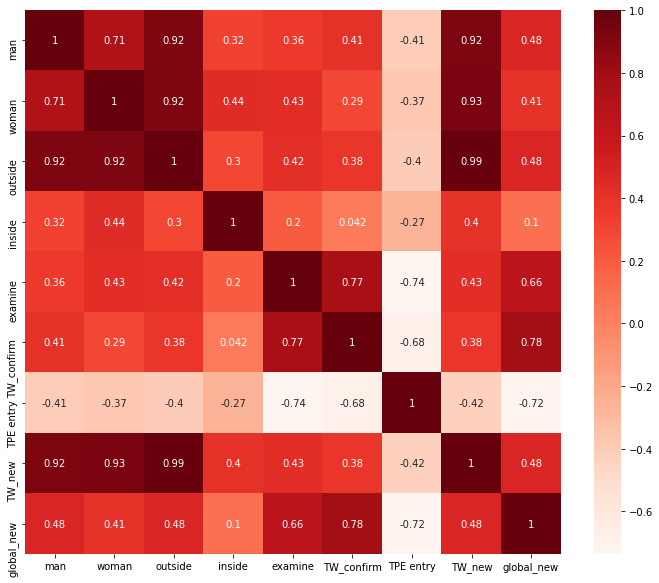

In [ ]:
# 特徵矩陣 feature matrix using Pearson Correlation
plt.figure(figsize=(12,10))
cor = mydataset_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## 3-產生目標 y值
(RNN 用不到)

In [ ]:
# 以預測一週後的台灣新增人數為目標
#dataset_df['y'] = dataset_df['TW_new'].shift(periods=-7)
#dataset_df

# 另存訓練資料集

# New Section

In [ ]:
# 自訂儲存路徑
path = '/content/drive/My Drive/Colab Notebooks'
mydataset_df.to_csv(path + '/dataset0421.csv')